### Initial Loading of Data from our data file

In [2]:
import cPickle as pickle
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
f = pickle.load(open('test4','rb'))

In [4]:
type(f)

list

In [5]:
len(f)

330071

So we have a list of 330k reviews composing the 250 closest businesses around 30 universities (see https://www.yelp.com/academic_dataset for more info).  In our previous step we created the this list of jsons from the overall dataset, removing items that dealt with users and businesses and keeping only records that dealt with reviews. 

In [6]:
f[11]

{u'business_id': u'jTPr0dFk2JgGYdDiIGro3Q',
 u'date': u'2007-12-11',
 u'review_id': u'sVI08gDOu79XzELwaRDiQw',
 u'stars': 5,
 u'text': u'After enduring years of crappy, undercooked, bad pizza in and around Ann Arbor (a la pizza house, cottage inn, and the like), Silvio\'s brings real pizza to town. Real pizza should be thin, have a crispy, bubbly, sourdough crust and be full of flavor, not grease, and this is the only place to get it.\n\nDon\'t be fooled by the "organic" part of the name, it really should be called "Silvio\'s Italian Pizza"\n\nBeware though, the more toppings you get on this pizza, the less well it cooks all the way through, and the less of a full pizza experience you get. The Margherita is a little light on the cheese, my only complaint.',
 u'type': u'review',
 u'user_id': u'NNFVXXEkb9Ur2ihVk_lW7A',
 u'votes': {u'cool': 0, u'funny': 0, u'useful': 0}}

Each item has the id for the business, user and review as well as the type and the date that this was created.  There is also the votes item which is a measure of how cool, funny, or useful other users found this review. The relevant fields for us however are text and stars (review score on a 1 to 5 scale).

## Using Sentiment to predict Review Score

We will try to use the sentiment of the review text to predict the score of the review.  For that we will use the VADER sentiment package and then train a naive Bayes classifier.

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

In [38]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [8]:
import nltk.sentiment.vader

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [10]:
sid = SentimentIntensityAnalyzer()

In [11]:
sid.polarity_scores(f[11]['text'])

{'compound': -0.7437, 'neg': 0.078, 'neu': 0.889, 'pos': 0.033}

Now note that we will not be cleaning or formatting the text because punctuations and capital letters have sentiment meaning.  Exclamation points and words that are in all capital letters can show an increased magnitude in the sentiment. 

In [12]:
import sklearn.cross_validation

In [13]:
trainset,testset = sklearn.cross_validation.train_test_split(f,random_state=620)

In [14]:
len(trainset)

247553

In [15]:
len(testset)

82518

Because of size and speed considerations, we will reduce the sets to 10% of their original size

In [16]:
trainset = [ trainset[i] for i in sorted(random.sample(xrange(len(trainset)), 24755)) ]
testset = [ testset[i] for i in sorted(random.sample(xrange(len(testset)), 8251)) ]

In [17]:
len(trainset)

24755

In [18]:
len(testset)

8251

In [19]:
def features(review):
    return sid.polarity_scores(review['text'])

We can first try a Naive Bayes classifier, but since features are not factors, this may not be very accurate

In [20]:
trainfeatures = [(features(n), n['stars']) for n in trainset]

In [21]:
testfeatures = [(features(n), n['stars']) for n in testset]

In [22]:
clf = nltk.NaiveBayesClassifier.train(trainfeatures)

In [23]:
print(nltk.classify.accuracy(clf, testfeatures))

0.354623681978


In [24]:
clf.show_most_informative_features(5)

Most Informative Features
                     neg = 0.113               1 : 5      =     35.3 : 1.0
                     neg = 0.135               1 : 4      =     32.6 : 1.0
                     neg = 0.148               1 : 4      =     30.0 : 1.0
                     pos = 0.024               1 : 4      =     28.5 : 1.0
                     pos = 0.037               1 : 4      =     26.0 : 1.0


We can try a Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [26]:
rfclf = RandomForestClassifier(n_jobs=2, n_estimators=3, max_features="auto",random_state=620)

In [27]:
def rfFeatures(review):
    return sid.polarity_scores(review['text']).values()

In [28]:
train_rf_1 = np.array([(rfFeatures(n)) for n in trainset])
train_rf_2 = np.array([n['stars'] for n in trainset])

In [29]:
test_rf_1 = np.array([(rfFeatures(n)) for n in testset])
test_rf_2 = np.array([n['stars'] for n in testset])

In [30]:
rfclf.fit(train_rf_1,train_rf_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=2,
            oob_score=False, random_state=620, verbose=0, warm_start=False)

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [32]:
test_rf_pred = rfclf.predict(test_rf_1)

In [33]:
cm = confusion_matrix(test_rf_2, test_rf_pred)

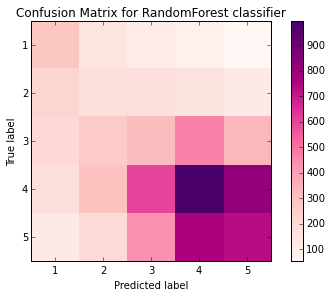

In [39]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdPu)
plt.title("Confusion Matrix for RandomForest classifier")
plt.colorbar()
tick_marks = np.arange(len(set(test_rf_2)))
plt.xticks(tick_marks, np.arange(1,6))
plt.yticks(tick_marks, np.arange(1,6))
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [40]:
accuracy_score(test_rf_2, test_rf_pred)

0.30238758938310506

In [41]:
print(classification_report(test_rf_2,test_rf_pred))

             precision    recall  f1-score   support

          1       0.28      0.41      0.33       686
          2       0.16      0.21      0.18       849
          3       0.19      0.20      0.20      1580
          4       0.40      0.34      0.37      2893
          5       0.35      0.33      0.34      2243

avg / total       0.31      0.30      0.31      8251



In [42]:
rfclf.feature_importances_

array([ 0.16513562,  0.21771897,  0.21449982,  0.40264559])